## 1.几个概念的区分
参考博客
[神经网络Linear、FC、FFN、MLP、Dense Layer等区别是什么？](https://www.zhihu.com/question/607822173/answer/3085671476)
1. Linear(线性层)：也成为全连接层（fully connencted/FC，全连接层是指**每个神经元都与上一层的所有神经元相连接**。每个连接都有一个权重，用于线性变换。）或密集层，接受输入并应用线性变换，将每个输入与相应的权重相乘并求和，然后加上偏置。该层没有激活函数。线性层常用于**将输入数据映射到下一层的特征空间**。

In [2]:
# 创建线性层
import torch
import torch.nn as nn

# 定义线性层
linear_layer = nn.Linear(in_features=10, out_features=5)

# 创建输入
input_data = torch.randn(1, 10)  # 假设输入维度为10

# 应用线性变换
output = linear_layer(input_data)
print(output)

tensor([[ 0.6315,  0.5053,  0.1660, -0.4380, -0.1619]],
       grad_fn=<AddmmBackward0>)


In [3]:
import torch
import torch.nn as nn

# 创建多层感知机模型
model = nn.Sequential(
    nn.Linear(in_features=10, out_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64, out_features=32),
    nn.ReLU(),
    nn.Linear(in_features=32, out_features=1),
    nn.Sigmoid()
)

# 创建输入
input_data = torch.randn(1, 10)  # 假设输入维度为10

# 前向传播
output = model(input_data)
print(output)

tensor([[0.4359]], grad_fn=<SigmoidBackward0>)


2. Feed-Forward Neural Netword(FFN/前馈神经网络) & MLP(Multilayer Perceptron/多层感知机)
它们在概念上是相同的。**前馈神经网络**是一种最常见的**神经网络结构**，由**多个全连接层组成，层与层之间是前向传播（数据的流动方向）的**。多层感知机是一种前馈神经网络的**具体实现**，其中至少有一个隐藏层。

In [4]:
import torch
import torch.nn as nn

# 创建前馈神经网络模型
class FFN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FFN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# 创建输入数据
input_data = torch.randn(1, 10)  # 假设输入维度为10

# 定义模型参数
input_size = 10
hidden_size = 64
output_size = 1

# 创建前馈神经网络模型实例
model = FFN(input_size, hidden_size, output_size)

# 前向传播
output = model(input_data)
print(output)

tensor([[0.1940]], grad_fn=<AddmmBackward0>)


---

## 2.从FFN到SwiGLU FFN
**介绍流程**

Swish->SiLU->GLU->SwiGLU->SwiGLU FFN

参考博客[FFN层激活函数](https://zhuanlan.zhihu.com/p/707504291)
### 2.1 Swish
Swish是一种**自门控（self-gated）激活函数**，用于深度学习模型中。Swish激活函数由于其自门控的特性，被认为在某些情况下能够提高模型性能，尤其是在模型较深时。此外，Swish在所有点上都是可微的，这有助于模型在训练过程中的优化。

自门控（self-gated）这个术语通常用于描述一种机制，其中模型**能够基于输入数据自身的**特征来**调节信息的**流动，而不需要额外的门控信号或外部控制。在深度学习和神经网络的上下文中，自门控机制允许网络单元根据输入数据的内在属性决定哪些信息应该被传递或强调，哪些应该被抑制。自门控机制的优点在于它们提供了一种灵活的方式来调节信息的流动，使模型能够更加精细地处理输入数据，从而提高模型的性能和泛力力。化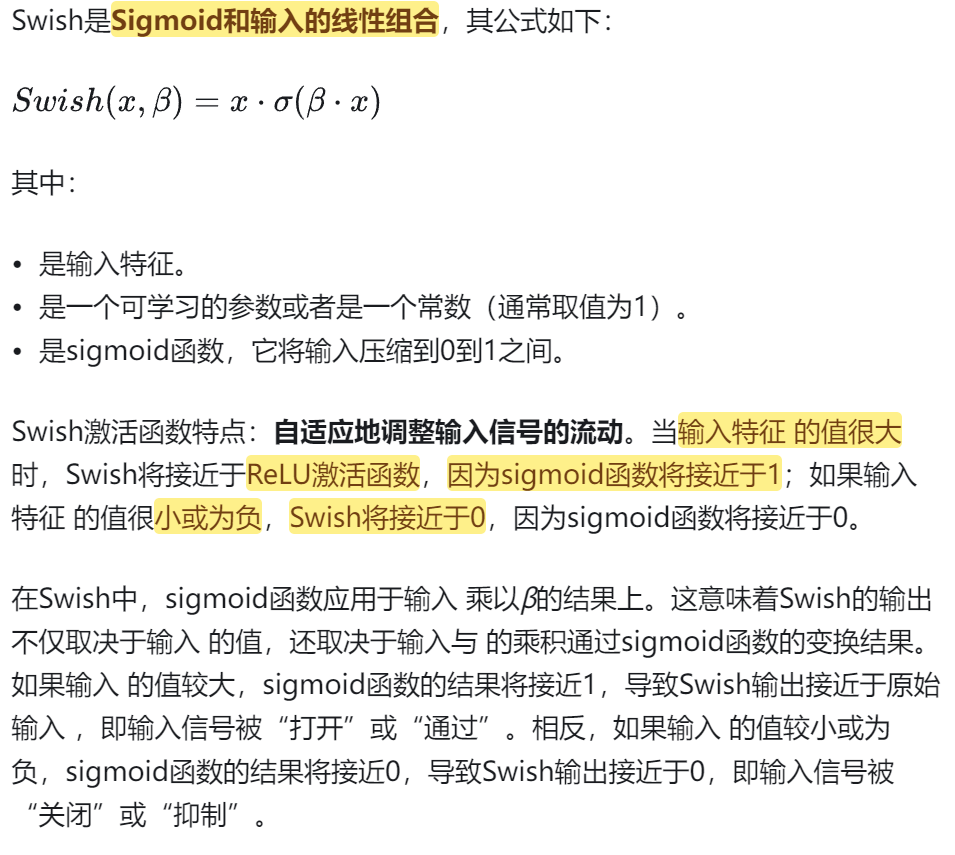力。

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Swish(nn.Module):
    def __init__(self, beta=1.0):
        super(Swish, self).__init__()
        self.beta = beta # 可学习的参数

    def forward(self, x):
        return x * torch.sigmoid(self.beta * x)

# 实例化Swish激活函数
swish = Swish(beta=1.0)

# 创建一个随机数据作为输入
x = torch.randn(10)  # 假设有10个随机输入特征

# 应用Swish激活函数
output = swish(x)
print(output)

tensor([-0.2298,  0.1027,  0.0485,  1.7923,  1.4856, -0.2733, -0.2415,  0.5886,
         0.4422, -0.1285])


### 2.2 SiLU(Sigmoid Linear Unit)
SiLU（Sigmoid Linear Unit），也称为**Swish激活函数的特例**，是一种**自门控的非线性激活函数**。SiLU在数学上等价于**将输入值与其通过sigmoid函数的结果相乘**，其公式如下：
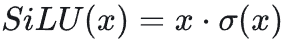

SiLU的特点是它在输入值为0时输出也为0，在输入值为正时输出接近于输入值本身，而在**输入值为负时输出则会压缩到0附近**。这使得SiLU在某些情况下比传统的ReLU激活函数表现得更好，尤其是在深度学习模型的深层中，因为它**允许负值**通过（而ReLU在负输入时输出为0）。

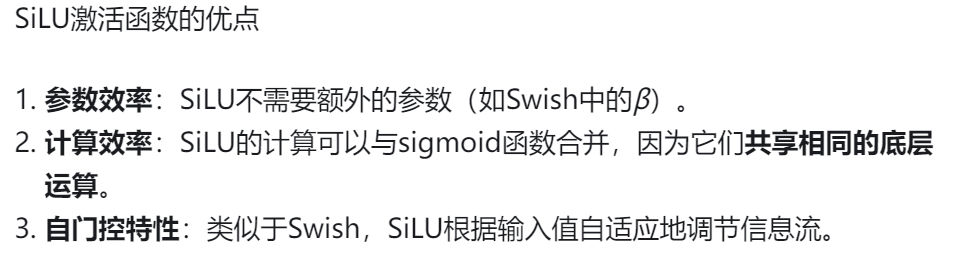

In [8]:
import torch
import torch.nn as nn

class SiLU(nn.Module):
    def __init__(self):
        super(SiLU, self).__init__()

    def forward(self, x):
        return x * torch.sigmoid(x)

silu = SiLU()
x = torch.randn(10)
output = silu(x)
print(output)

tensor([ 0.0509, -0.2766, -0.2622,  0.4113, -0.2770,  0.2464, -0.2765, -0.2767,
        -0.2680, -0.2498])


### 2.3 GLU(Gated Linear Units)
GLU（Gated Linear Units）激活函数是一种门控机制的线性变换，它在神经网络中用于控制信息的流动。GLU由两个线性变换组成，一个是**输入的线性变换，另一个是门控信号的线性变换**。门控信号是一个**sigmoid函数的输出**，它决定了输入信息的多少可以通过。GLU的结构使得网络能够自适应地选择输入特征的重要部分，从而提高模型对数据的表征能力

GLU通常作为更复杂模型中的一个组件，例如在Transformer模型的FFN（Feed-Forward Networks）中。

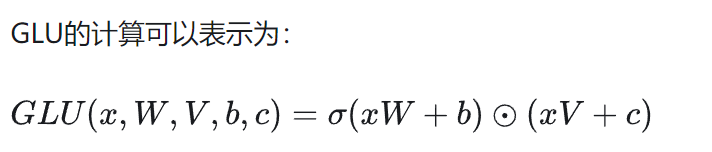

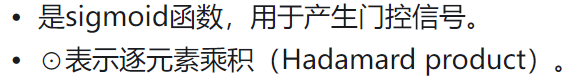

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GLU(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GLU, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(input_dim, hidden_dim)

    def forward(self, x):
        gate = torch.sigmoid(self.linear1(x))  # 门控信号
        return gate * self.linear2(x)  # 门控后的线性变换输出

# 假设输入维度是512，隐藏层维度是2048
input_dim = 512
hidden_dim = 2048

# 实例化GLU
glu = GLU(input_dim, hidden_dim)

# 创建一个随机数据作为输入
x = torch.randn(10, input_dim)  # (batch_size, input_dim)

# 前向传播通过GLU
output = glu(x)
print(output)

tensor([[-0.3735,  0.0322, -0.3305,  ...,  0.1000,  0.2458,  0.2207],
        [-0.0739, -0.0387,  0.3410,  ...,  0.2390, -0.2320, -0.6525],
        [ 0.0245,  0.0302,  0.0267,  ...,  0.1369,  1.0606,  0.1962],
        ...,
        [-0.0479, -0.4991, -0.0378,  ..., -0.7233,  1.2104, -0.1272],
        [-0.1283, -0.3176, -0.1501,  ..., -0.2239, -0.1480,  0.0113],
        [ 0.3307,  0.1201,  0.1626,  ...,  0.1212,  0.1044, -0.1189]],
       grad_fn=<MulBackward0>)


### 2.4 SwiGLU(Swish + GLU)
SwiGLU激活函数是一种在大型语言模型中广泛使用的激活函数，特别是在PaLM和LLaMA模型中。它是基于GLU（Gated Linear Units）的变体，由Noam Shazeer在论文《GLU Variants Improve Transformer》中提出。**SwiGLU结合了Swish激活函数 和 GLU门控机制的特点**，以增强Transformer模型中FFN层的性能

**计算描述**

1. 使用权重矩阵$W$和偏置$b$(可选)对输入x进行线性变换。
2. 使用Swish激活函数对上述结果进行激活，其中beta在LLaMA中常取1（**也就是将Swish替换为SiLU**）。
3. 使用另一个权重矩阵$V$和偏置$c$(可选)对原始输入x进行另一个线性变换。
4. 将步骤1的结果和步骤3的结果进行逐元素乘积（Hadamard product），得到最终的SwiGLU激活输出。

### 2.5 SwiGLU FFN

就相当于对SwiGLU的输出再进行一次线性变换

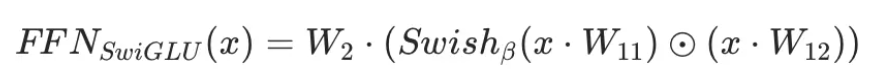

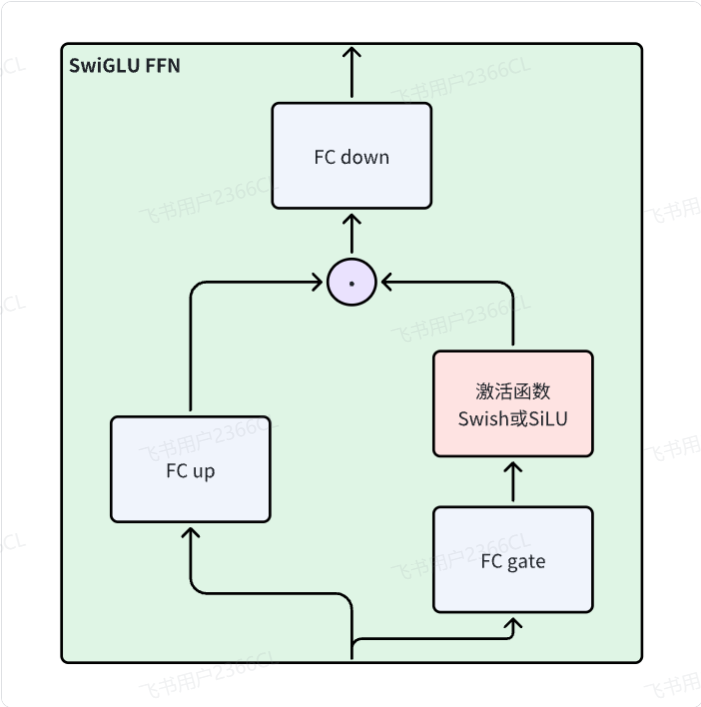

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 定义Swish激活函数
def silu(x):
    return x * torch.sigmoid(x)

# 定义带有SwiGLU激活函数的FFN模块
class SwiGLU_FFN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SwiGLU_FFN, self).__init__()
        # 第一个全连接层
        # 用于线性变换+SwiGLU激活函数
        self.fc_gate = nn.Linear(input_dim, hidden_dim)
        # 用于线性变换
        self.fc_up = nn.Linear(input_dim, hidden_dim)
        
        # 第二个全连接层，输出维度与输入维度相同
        self.fc_down = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # 第一层全连接
        # SwiGLU激活函数
        SiLU = (self.fc_gate(x))
        # 哈达玛积
        hadamard_product = SiLU * self.fc_up(x)
        
        # 第二层全连接
        output = self.fc_down(hadamard_product)
        return output

input_dim = 8
hidden_dim = 16
output_dim = input_dim

# 实例化SwiGLU_FFN
ffn_layer = SwiGLU_FFN(input_dim, hidden_dim, output_dim)

# 创建一个随机数据作为输入
x = torch.randn(10, input_dim)  # (batch_size, input_dim)

# 前向传播通过FFN层
output = ffn_layer(x)

print(output)

tensor([[ 0.0679, -0.3457, -0.4926,  0.0291,  0.1255,  0.1152,  0.3478, -0.1013],
        [-0.1128, -0.3589, -0.5214,  0.1456, -0.2448,  0.0433,  0.1628, -0.2547],
        [ 0.3136, -0.9075, -0.4460,  0.2774,  0.2055,  0.1142,  0.6170,  0.3393],
        [ 0.0853, -0.5327, -0.2529,  0.1957,  0.3829, -0.3068,  0.3424, -0.3580],
        [ 0.2436, -0.2165, -0.0441,  0.1591,  0.4510,  0.2698,  0.0171, -0.2442],
        [ 0.1300, -0.0804, -0.2694, -0.0582, -0.0031,  0.1492,  0.2199, -0.2488],
        [ 0.1033, -0.2072, -0.1698, -0.1341, -0.3470,  0.3792,  0.0116, -0.2114],
        [ 0.3659,  0.2563,  0.0724,  0.1805, -0.7550,  0.0829,  0.3612, -0.8034],
        [ 0.0671, -0.5450, -0.3705, -0.0360, -0.0523, -0.1340,  0.4223, -0.3214],
        [ 0.1492,  0.0090, -0.2256,  0.0100, -0.1425,  0.1769,  0.2953, -0.2744]],
       grad_fn=<AddmmBackward0>)


---

## 3. 本项目中的代码实现

In [ ]:
class SiLU(Function):
    def forward(self, x: np.ndarray) -> tuple[np.ndarray]:
        self.sigmoid = 1 / (1 + np.exp(-x))
        y = x * self.sigmoid
        return y

    def backward(self, gy: np.ndarray) -> Union[tuple[np.ndarray, ...], np.ndarray]:
        y = self.outputs[0]()
        gx = gy * (y + self.sigmoid * (1 - y))
        # y'=(xs)'=s+xs(1-s)=s+xs-xss=xs+s(1-xs)=y+s(1-y)
        return gx


def silu(x):
    return SiLU()(x)


class SwiGLUFeedForwardNetwork(Model):
    def __init__(self, hidden_size: int, intermediate_size: int, use_bias: bool = False):
        super(SwiGLUFeedForwardNetwork, self).__init__()
        self.fc_gate = Linear(in_size=hidden_size, out_size=intermediate_size, nobias=~use_bias)
        self.fc_up = Linear(in_size=hidden_size, out_size=intermediate_size, nobias=~use_bias)
        self.fc_down = Linear(in_size=intermediate_size, out_size=hidden_size, nobias=~use_bias)

    def forward(self, x):
        x1 = self.fc_up(x)
        x = silu(self.fc_gate(x))
        x = x * x1
        x = self.fc_down(x)
        return x